2025.03.30, Zhang Chao<br>
Show the cooling dynamics from 2001 to 2020 for China and four climate zones

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
import seaborn as sns
import pymannkendall as mk
import matplotlib.lines as mlines
import matplotlib as mpl
import sys
import scipy
import os
from cartopy.feature import ShapelyFeature
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))
from utils import getSigFlag,compute_mk_trend, stats_regionratio
sys.path.append('/home/climate/chaoz/code/utils/')
from plot_utils import plot_settings

In [2]:
import matplotlib
import cartopy
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Cartopy version: {cartopy.__version__}")

Matplotlib version: 3.9.1
Cartopy version: 0.24.0


In [3]:
os.chdir('/home/climate/chaoz/project/03Irr_Ts_CN/processed/')

dLSTday = xr.open_dataset('delta_LSTday_Yr_CN_2001_2020.nc')
dLSTnight = xr.open_dataset('delta_LSTnight_Yr_CN_2001_2020.nc')
IWU = xr.open_dataset('IWU_2003_2020.nc')

# Below two input files were produced by './2_process/01_delta_LST_Mn.ipynb'
dLSTday_Mn   = xr.open_dataset('delta_LSTday_Mn_CN_2001_2020.nc')
dLSTnight_Mn = xr.open_dataset('delta_LSTnight_Mn_CN_2001_2020.nc')

shp_cn = gpd.read_file('../shapefile/ChinaAll.shp')
shp_nanhai = gpd.read_file('../shapefile/Nanhai.shp')
shp_climzone = gpd.read_file('../shapefile/ClimateZone_3.shp')

In [4]:
def get_df_dLST_Mn_trends(df0):
    df = df0.copy()

    # Convert 'time' column to datetime format
    df['time'] = pd.to_datetime(df['time'])
    
    # Extract month and year
    df['month'] = df['time'].dt.month
    df['year'] = df['time'].dt.year
    
    # Group by month and compute trends within each month
    slope_list = []
    pval_list = []
    
    
    for month in range(1,13): # Loop through months 1 to 12
        df_month = df[df['month'] == month].sort_values(by='year', ascending=True)
        
        trends = df_month[['China', 'Arid', 'Semi', 'Humid']].apply(compute_mk_trend).T
        trends.columns=['slope','pval']
        
        slopes = trends['slope'].copy()
        slopes['month'] = month
        slope_list.append(slopes)
        
        pvals = trends['pval'].copy()
        pvals['month'] = month
        pval_list.append(pvals)
        
    df_slope = pd.DataFrame(slope_list).reset_index(drop=True)
    df_pval = pd.DataFrame(pval_list).reset_index(drop=True)
    
    # Reorder columns
    df_slope = df_slope[['month', 'China', 'Arid', 'Semi', 'Humid']]
    df_pval  = df_pval[['month' , 'China', 'Arid', 'Semi', 'Humid']]

    return df_slope, df_pval

In [5]:
'''
Get the regional means of dLSTday, dLSTnight, and IWU
Calculation of these regional means is time-consuming (>40 min), 
So, I output the results to csv files and read them again for plotting figures
'''
# df_dLSTday      = stats_regionmean(dLSTday  ,'Ts',shp_climzone)
# df_dLSTnight    = stats_regionmean(dLSTnight,'Ts',shp_climzone)
# df_dLSTday_Mn   = stats_regionmean(dLSTday_Mn  ,'Ts',shp_climzone)
# df_dLSTnight_Mn = stats_regionmean(dLSTnight_Mn  ,'Ts',shp_climzone)
# df_IWU          = stats_regionmean(IWU,'iwu',shp_climzone)

# df_dLSTday.to_csv('regionmean_dLSTday_Yr.csv')
# df_dLSTnight.to_csv('regionmean_dLSTnight_Yr.csv')
# df_IWU.to_csv('regionmean_IWU_Yr.csv')
# df_dLSTday_Mn.to_csv('regionmean_dLSTday_Mn.csv')
# df_dLSTnight_Mn.to_csv('regionmean_dLSTnight_Mn.csv')

df_dLSTday      = pd.read_csv('regionmean_dLSTday_Yr.csv')
df_dLSTnight    = pd.read_csv('regionmean_dLSTnight_Yr.csv')
df_IWU          = pd.read_csv('regionmean_IWU_Yr.csv')
df_dLSTday_Mn   = pd.read_csv('regionmean_dLSTday_Mn.csv')
df_dLSTnight_Mn = pd.read_csv('regionmean_dLSTnight_Mn.csv')

In [6]:
# Get trend (with p-value) of monthly delta_LST at the regional scale
df_Day_Mn_slope,df_Day_Mn_pval     = get_df_dLST_Mn_trends(df_dLSTday_Mn)
df_Night_Mn_slope,df_Night_Mn_pval = get_df_dLST_Mn_trends(df_dLSTnight_Mn)

In [7]:
def plot_regionwater(fig,axpos,data,No):
    '''Plot the IWU (irrigation water use) time series'''
    ax=fig.add_axes(axpos)
    x = range(2003, 2021)
    y = data * 15/1000#scale to m3/ha  # * 0.0666666666667

    ###
    ax.plot(x, y, 'b-', label='IWU')

    ax.set_ylabel('')
    ax.set_xlim(2000,2021)
    ax.set_xticks([2005,2015], [])
    parameter = np.polyfit(x, y, 1)
    f = np.poly1d(parameter)
    r, sig = scipy.stats.pearsonr(x, y)
    ax.plot(x, f(x), ls='--', c='b')
    ax.text(-0.15,1.05, No, transform=ax.transAxes, c='k',
             weight='bold',fontsize=16)  # ,style='italic'
    
    ax.set_ylim(2.5, 13)
    
    ax.text(0.10, 0.95, "slope = %.2f$^{%s}$" %
             (parameter[0] * 10, getSigFlag(sig)),
             transform=ax.transAxes, c='k',fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    return ax


def plot_regiondLSTday(fig, axpos, data, colori, No):
    # Define positions for the two sub-axes
    pos1 = [axpos[0], axpos[1] + axpos[3] * 0.5+0.008, axpos[2], axpos[3] * 0.5-0.008]  # Upper part
    pos2 = [axpos[0], axpos[1], axpos[2], axpos[3] * 0.5-0.008 ]  # Lower part

    # Create two axes for the broken y-axis
    ax1, ax2 = fig.add_axes(pos1), fig.add_axes(pos2)

    x = np.arange(1, 21)
    y = data

    # **Set Y-axis limits based on breaks**
    ax1.set_ylim([-0.4, 0.15])  # Upper part
    ax2.set_ylim([-2.65, -2.1])  # Lower part

    # **Plot data on both axes**
    ax1.plot(x, y, c=colori)
    ax2.plot(x, y, c=colori)

    # **Fit and plot trend line**
    r, sig = scipy.stats.pearsonr(x, y)
    parameter = np.polyfit(x, y, 1)
    f = np.poly1d(parameter)
    ax1.plot(x, f(x), ls='--', c=colori)
    ax2.plot(x, f(x), ls='--', c=colori)

    # **Add annotations**
    ax1.text(-0.15, 1.05, No, transform=ax1.transAxes, c='k', weight='bold', fontsize=16)
    ax1.text(0.10, 0.95, "slope = %.2f$^{%s}$" % (parameter[0] * 10, getSigFlag(sig)), 
             transform=ax1.transAxes, c='k',fontsize=12)

    # **Customize axes: Hide top of ax2 and bottom of ax1**
    ax1.spines["bottom"].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines['right'].set_visible(False)

    # **Draw diagonal break marks**
    d = .015  # Offset for diagonal lines
    kwargs = dict(transform=ax1.transAxes, color='k', linewidth=1, clip_on=False)
    ax1.plot((-d, +d), (-d, +d - 0.015), **kwargs)  # Top-left diagonal
    kwargs.update(transform=ax2.transAxes)  # Switch to the lower axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # Bottom-left diagonal

    # **Handle X-axis formatting**
    ax2.set_xticks([5, 15])
    ax2.set_xticklabels([2005, 2015])

    # **Set ylabel only for upper axis**
    ax1.set_ylabel('')
    ax1.set_yticks([-0.5,0],[-0.5,0])
    ax2.set_yticks([-2.5,-2.0],[-2.5,-2.0])
    ax1.set_xticks([])
    ax2.set_xticklabels([])  # Remove x-ticks from the lower axis

    return ax1 # Return the two axes


def plot_regiondLSTnight(fig,axpos,data,colori,No):
    ax=fig.add_axes(axpos)
    x = range(1, 21)

    y = data
    ax.plot(x, y, c=colori)

    parameter = np.polyfit(x, y, 1)
    f = np.poly1d(parameter)
    r, sig = scipy.stats.pearsonr(x, y)
    ax.plot(x, f(x), ls='--', c=colori)

    ax.text(-0.15,1.05,No,transform=ax.transAxes,c='k',
             weight='bold',fontsize=16)
    ax.text(0.10,0.90, "slope = %.2f$^{%s}$" %
             (parameter[0]*10, getSigFlag(sig)),
             transform=ax.transAxes, c= 'k',fontsize=12)
    ax.set_xlim(0,21)
    ax.set_ylim([-0.30,0.12])
    ax.set_xticks([5,15], [2005,2015])
    ax.set_xlabel('Year')
    ax.set_ylabel('')
    ax.set_yticks([-0.2,-0.1,0],[-0.2,-0.1,0])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return ax


def drawScatterPlots(fig,axpos,x0,y1,y2,xticks,yticks,ylim,legendFlag,No):
    ax=fig.add_axes(axpos)
    x  = x0 *15/1000
    colors = ['#1a8076','#be7d27','k']

    ###
    y = y1[2:]
    sns.regplot(x=x, y=y,ax=ax,marker='o',color=colors[0],label='Daytime',
                line_kws = {'linewidth':2},scatter_kws={'s':12})
    parameter = np.polyfit(x,y,1)
    f = np.poly1d(parameter)
    r, sig = scipy.stats.pearsonr(x, y)
    ax.text(0.08, 0.90, "R\u00b2 = ",transform=ax.transAxes,fontsize=12)
    ax.text(0.55, 0.90, ",", transform=ax.transAxes,fontsize=12)
    ax.text(0.28, 0.90, "%.2f$^{%s}$" % (r * r, getSigFlag(sig)),
             transform=ax.transAxes, c=colors[0],fontsize=12)
    ###
    y = y2[2:]
    sns.regplot(x=x, y=y,ax=ax,marker='^',color=colors[1],label='Nighttime',
                line_kws = {'linewidth':2},scatter_kws={'s':12})
    parameter = np.polyfit(x, y, 1)
    f = np.poly1d(parameter)
    r, sig = scipy.stats.pearsonr(x, y)
    ax.text(0.63, 0.90, "%.2f$^{%s}$" % (r * r, getSigFlag(sig)),
             transform=ax.transAxes, c=colors[1],fontsize=12)

    ax.text(-0.12,1.05,No,transform = ax.transAxes,
             weight = 'bold',fontsize=14)
    
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticks(xticks,xticks)
    ax.set_yticks(yticks,yticks)
    ax.set_ylim(ylim)
    
    ax.set_yticks(yticks,yticks)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    
    # Create custom legend handles
    handles = [
        mlines.Line2D([], [], color='b', linestyle='-', label='IWU'),
        mlines.Line2D([], [], color=colors[0], linestyle='-', label='$\Delta$LST_Day'),
        mlines.Line2D([], [], color=colors[1], linestyle='-', label='$\Delta$LST_Night'),
    ]
    
    # Add legend to the main plot
    if legendFlag:
        ax.text(0.1,0.1,'Day',transform=ax.transAxes,c=colors[0],fontsize=12)
        ax.text(0.1,0.7,'Night',transform=ax.transAxes,c=colors[1],fontsize=12)
        
    ax.set_xlabel('IWU [1e3 m$^{3}$/ha]')
    return ax


def drawMapPlots(ax0,axpos,shape_cn, shape_nanhai,shape_cz,zone):
    lambert_proj = ccrs.LambertConformal(central_longitude=105, central_latitude=35, standard_parallels=(25, 47))
    # ax = fig.add_axes(axpos, projection=lambert_proj, frame_on=False)
    ax = ax0.inset_axes(axpos,projection=lambert_proj,frame_on=False)
    extent = [72, 136, 8, 55]
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    fea_cn = ShapelyFeature(shape_cn.geometry, crs=ccrs.PlateCarree(), facecolor='#cccccc')
    fea_nanhai = ShapelyFeature(shape_nanhai.geometry, crs=ccrs.PlateCarree(), facecolor='#cccccc')
    ax.add_feature(fea_cn)
    ax.add_feature(fea_nanhai,edgecolor='#cccccc',linewidth=.2)
    if zone == 'China':
        ax.add_feature(fea_cn,facecolor='#343434')
    else:
        selected = shape_cz[shape_cz['zone'] == zone]
        fea_climzone = ShapelyFeature(selected.geometry,crs=ccrs.PlateCarree(), facecolor='#343434')
        ax.add_feature(fea_climzone)
    
    ax.patch.set_visible(False)
    return ax

Plotting figures

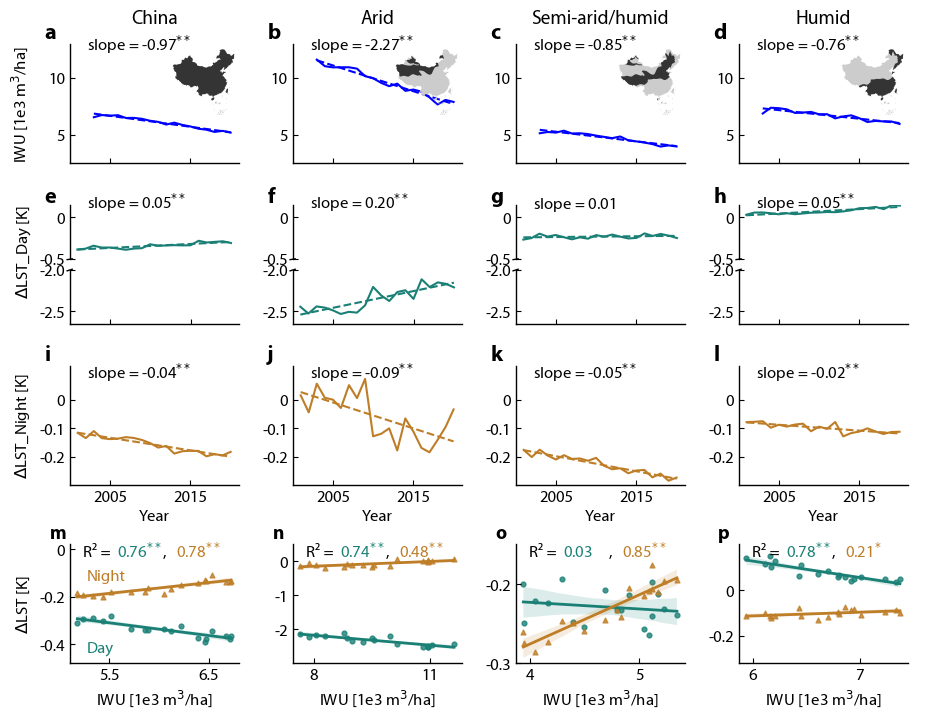

In [9]:
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

extent = [80, 127,15,54] # China map illustration extent

fig = plt.figure(figsize=(9,7))
plot_settings()

colors = ['#1a8076','#be7d27','k']

x0,y0 = 0.069,0.09
xi,yi = 0.06,0.06
hx1,vx1 = (1-x0-3*xi)/4,0.17

pos11 = [x0+(hx1+xi)*0, y0+(vx1+yi)*3, hx1, vx1]
pos12 = [x0+(hx1+xi)*1, y0+(vx1+yi)*3, hx1, vx1]
pos13 = [x0+(hx1+xi)*2, y0+(vx1+yi)*3, hx1, vx1]
pos14 = [x0+(hx1+xi)*3, y0+(vx1+yi)*3, hx1, vx1]

pos21 = [x0+(hx1+xi)*0, y0+(vx1+yi)*2, hx1, vx1]
pos22 = [x0+(hx1+xi)*1, y0+(vx1+yi)*2, hx1, vx1]
pos23 = [x0+(hx1+xi)*2, y0+(vx1+yi)*2, hx1, vx1]
pos24 = [x0+(hx1+xi)*3, y0+(vx1+yi)*2, hx1, vx1]

pos31 = [x0+(hx1+xi)*0, y0+(vx1+yi)*1, hx1, vx1]
pos32 = [x0+(hx1+xi)*1, y0+(vx1+yi)*1, hx1, vx1]
pos33 = [x0+(hx1+xi)*2, y0+(vx1+yi)*1, hx1, vx1]
pos34 = [x0+(hx1+xi)*3, y0+(vx1+yi)*1, hx1, vx1]

pos41 = [x0+(hx1+xi)*0, y0+(vx1+yi)*0-0.025, hx1, vx1]
pos42 = [x0+(hx1+xi)*1, y0+(vx1+yi)*0-0.025, hx1, vx1]
pos43 = [x0+(hx1+xi)*2, y0+(vx1+yi)*0-0.025, hx1, vx1]
pos44 = [x0+(hx1+xi)*3, y0+(vx1+yi)*0-0.025, hx1, vx1]

# Top row: time-series regional irrigation water use per hectare
ax11 = plot_regionwater(fig,pos11, df_IWU['China'],'a')
ax12 = plot_regionwater(fig,pos12, df_IWU['Arid'] ,'b')
ax13 = plot_regionwater(fig,pos13, df_IWU['Semi'] ,'c')
ax14 = plot_regionwater(fig,pos14, df_IWU['Humid'],'d')

# China map inside the top-row figures 
ax11i = drawMapPlots(ax11,[0.5, 0.4, 0.6, 0.6],shp_cn,shp_nanhai, shp_climzone,'China')
ax12i = drawMapPlots(ax12,[0.5, 0.4, 0.6, 0.6],shp_cn,shp_nanhai, shp_climzone,'Arid')
ax13i = drawMapPlots(ax13,[0.5, 0.4, 0.6, 0.6],shp_cn,shp_nanhai, shp_climzone,'Semi')
ax14i = drawMapPlots(ax14,[0.5, 0.4, 0.6, 0.6],shp_cn,shp_nanhai, shp_climzone,'Humid')

# Second row: time-series regional delta_LST at the daytime
ax21 = plot_regiondLSTday(fig,pos21,df_dLSTday['China'],colors[0],'e')
ax22 = plot_regiondLSTday(fig,pos22,df_dLSTday['Arid'] ,colors[0],'f')
ax23 = plot_regiondLSTday(fig,pos23,df_dLSTday['Semi'] ,colors[0],'g')
ax24 = plot_regiondLSTday(fig,pos24,df_dLSTday['Humid'],colors[0],'h')

# Third row: time-series regional delta_LST at the nighttime
ax31 = plot_regiondLSTnight(fig,pos31,df_dLSTnight['China'],colors[1],'i')
ax32 = plot_regiondLSTnight(fig,pos32,df_dLSTnight['Arid'] ,colors[1],'j')
ax33 = plot_regiondLSTnight(fig,pos33,df_dLSTnight['Semi'] ,colors[1],'k')
ax34 = plot_regiondLSTnight(fig,pos34,df_dLSTnight['Humid'],colors[1],'l')

# Fourth row: correlation relationship between IWU and delta_LST fot daytime and nighttime
ax41 = drawScatterPlots(fig,pos41,df_IWU['China'],df_dLSTday['China'],df_dLSTnight['China'],[5.5,6.5],[0,-0.2,-0.4],[-0.48,0.02],True, 'm')
ax42 = drawScatterPlots(fig,pos42,df_IWU['Arid'] ,df_dLSTday['Arid'] ,df_dLSTnight['Arid'] ,[8,11]   ,[0,-1,-2]    ,[-3,0.5]    ,False,'n')
ax43 = drawScatterPlots(fig,pos43,df_IWU['Semi'] ,df_dLSTday['Semi'] ,df_dLSTnight['Semi'] ,[4,5]    ,[-0.3,-0.2]  ,[-0.3,-0.15],False,'o')
ax44 = drawScatterPlots(fig,pos44,df_IWU['Humid'],df_dLSTday['Humid'],df_dLSTnight['Humid'],[6,7]    ,[-0.2,0]     ,[-0.32,0.2] ,False,'p')

ax11.set_title('China',pad=15)
ax12.set_title('Arid',pad=15)
ax13.set_title('Semi-arid/humid',pad=15)
ax14.set_title('Humid',pad=15)
ax11.set_ylabel('IWU [1e3 m$^{3}$/ha]',labelpad=12)
ax21.set_ylabel('$\Delta$LST_Day [K]')
ax21.yaxis.set_label_coords(-0.22,0.15)
ax31.set_ylabel('$\Delta$LST_Night [K]',labelpad=5)
ax41.set_ylabel('$\Delta$LST [K]',labelpad=5)

# plt.savefig('../figures/Figure_01.png',dpi=300)
plt.savefig('../figures/Figure_01.pdf')